In [38]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

#### Prepare for Dataset

In [39]:
file  = open('SeriesOfUnforunateEvents-Book9-Chapter1.txt').read()
unique_chars = {}
idx = 0
for char in file:
    if char not in unique_chars:
        unique_chars[char] = idx
        idx += 1
n_chars = len(unique_chars.keys())
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(unique_chars.keys()))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 245191
All possible characters: dict_keys(['W', 'h', 'e', 'n', ' ', 'm', 'y', 'w', 'o', 'r', 'k', 'd', 'a', 'i', 's', 'v', ',', 'I', 'c', 'l', 't', 'b', 'p', '\n', 'f', 'u', 'g', '.', 'S', 'A', 'z', 'B', 'F', '“', '”', 'x', '’', 'T', '-', 'U', 'j', 'q', 'C', 'O', 'E', 'V', 'K', 'L', 'M', 'N', '?', 'Y', 'D', 'P', '!', 'R', 'G', 'H', '‘', 'Q', '5', 'J', '9', "'", '6', '7', ':', '—', 'X', '¬'])
Number of all possible characters: 70


In [40]:
decoded_chars = {}
for key in unique_chars.keys():
    val = unique_chars[key]
    decoded_chars[val] = key

In [41]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = unique_chars[char]
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = unique_chars[char]
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [42]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


#### Network Definition

In [43]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.hidden_layer = nn.RNNCell(self.input_size,self.hidden_size) 
        self.output_layer = nn.Linear(self.hidden_size,self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.hidden_layer(input,hidden)
        output = self.output_layer(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (hidden_layer): RNNCell(70, 100)
  (output_layer): Linear(in_features=100, out_features=70, bias=True)
)

#### Training Step and Evaluation Step

In [44]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [45]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = decoded_chars[predicted_index.item()]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [46]:
# Number of iterations.
iters       = 20000  # Number of training iterations.
print_iters = 200    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:199/20000 loss:2.824873685836792
generated sequence: WLor,her” pee oues shiud song sn
s.nlly t” wfinto nn flir ct sonh oid sis udnnrit tot ang cot her un 



KeyboardInterrupt: 

#### Training Loss Curve

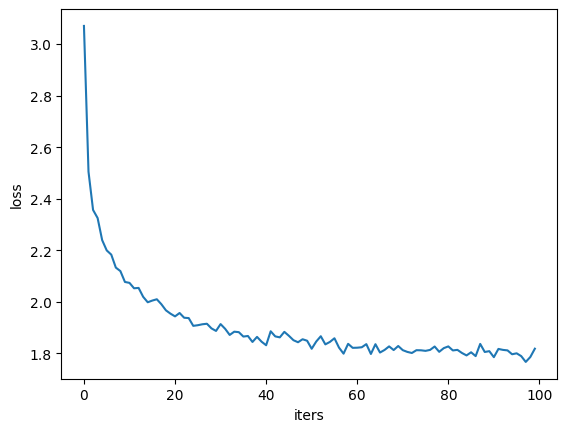

In [ ]:
plt.xlabel('iters')
plt.ylabel('loss')
all_losses = [loss.item() for loss in all_losses]
plt.plot(np.array(all_losses))
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [ ]:
print(eval_step(net, predicted_len=600))

Wherednspons welced.

PROSPARUEL:
God thy bohe urefoftion say werance is was that make decamtnother your be reatant is.

GREAN MOBHOM:
Guns ef-be retters such renot cenies,
Is new doth he pray'd, which I will note, seridor hearthal our by kins.

LADY GVIZARNTES:
When my law-theel,
At me you, knecery the cannsire:
ImbYe one, allay one then speak buctee
And rrve weckest eneshtirt makch?
And rempnammersent whele, you head so mimile.
One the's;
Or bold: marks so,
And nite fromnt that it nackly heards.

LADWAND:
Nurrest upon of
Lones, atim.
Befor,
Than nesser.

KAGHAHAS:
Well you are I know.

PRASUS


### Method

This is the original method employed in class. Serves as a baseline to all my work succeeding it.

### Evaluation

The input is relatively sensible, since we are able to understand some of the phrases -- at the very least, we are able to identify that most of the words resembles English words and generates sentence like output..